In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os

In [2]:
plt.style.use("ggplot")

In [34]:
def _load_data(file_name, repo, use_most_recent_file=True, parameter=None):
    if use_most_recent_file:
        try:
            file_name = sorted(glob.glob(f"./data/{repo}/{file_name}" + "*.json" ))[-1]
        except IndexError:
            raise ValueError(f"Data file {file_name} not found for {repo}.")
        assert os.path.exists(file_name), "no file found"
    else:
        file_name = "./data/{repo}/{file_name}.json"
        assert os.path.exists(file_name), "no file found"

    print(f"Loaded {repo} data from ", file_name)

    with open(file_name, "r") as f:
        data = json.load(f)

    # if not specified, load the first we encounter in the JSON
    if parameter is None:
        parameter = list(data[0]["params"].keys())[0]
    param_values = np.array([dat["params"][parameter] for dat in data])
    time_values = np.array([dat["time"] for dat in data])
    return param_values, time_values, file_name, parameter

def compare_plot(file_name, time_units="min", use_most_recent_file=True, parameter=None, save_fig=False):
    
    def _plot(x, y, label=""):
        if time_units == "min": y /= 60.
        p = plt.plot(x, y, '.', label=label)
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b, '--', color=p[0].get_color())

    ssm_old = _load_data(file_name, "ssm_old", use_most_recent_file, parameter)
    ssm_jax = _load_data(file_name, "ssm_jax", use_most_recent_file, parameter)
    plot_name = ssm_old[-2].split("/")[-1].split("-")[0]
    assert ssm_old[-1] == ssm_jax[-1], "parameter mismatch between ssm_old and ssm_jax!"

    plt.figure(figsize=(8, 5))
    _plot(*ssm_old[:2], label="SSM")
    _plot(*ssm_jax[:2], label="SSM JAX")

    plt.xlabel(f"{ssm_old[-1]}")
    plt.ylabel(f"Time Elapsed ({time_units})")
    plt.legend()
    if save_fig: plt.savefig(f"./plots/{plot_name}.png", dpi=200)
    plt.show()

Loaded ssm_old data from  ./data/ssm_old/hmm_em.time_hmm_em.num_timesteps-20211019-190456.json
Loaded ssm_jax data from  ./data/ssm_jax/hmm_em.time_hmm_em.num_timesteps-20211019-190358.json


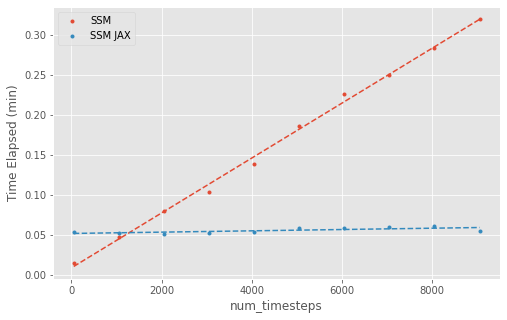

In [39]:
compare_plot("hmm_em", save_fig=True)

Loaded ssm_old data from  ./data/ssm_old/lds_em.time_lds_em.num_timesteps-20211019-191125.json
Loaded ssm_jax data from  ./data/ssm_jax/lds_em.time_lds_em.num_timesteps-20211019-191508.json


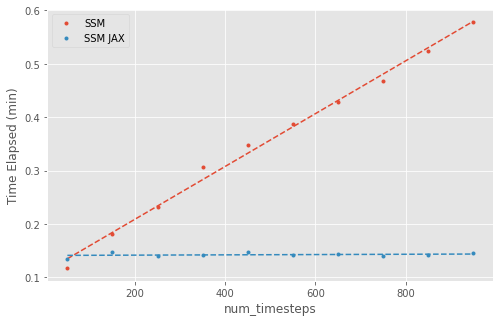

In [37]:
compare_plot("lds_em.time_lds_em.num_timesteps", save_fig=True)